In [1]:
# !jt -t monokai -f fira -fs 13 -nf ptsans -nfs 11 -N -kl -cursw 5 -cursc r -cellw 95% -T

In [2]:
# !jt -t grade3

# House pricing project

In this project, we would like to explore the house dataset and build models to predict house price. In summary, here are how we approach this problem.
1. explore both numerical and categorical features. Plot histogram/density/heatmap to understand feature distribution.
2. Feature engineering: As we know, location is one of important features to predict price of house. Beside using those original features, we also focus on how to extract information from ADDRESS column. For example, ADDRESS can be splitted into 2 additional columns, called CITY and SUB_CITY. We consider avg/std of number of room, sq-feet, and unit price per sq-feet for each city. And use them as additional features.
3. Modeling: we did several modelings:
   * Baseline model: linear regression + raw features (i.e. not include derived features).
   * Run several models + selected features ( using Variance inflation factor ).
   * Run grid search + cross validation on selected models due to limited time.
   * Stacking Regression.
   * Voting Regression.
   * Neural Network (sklearn) + grid search + cross validation.

## Exploration Data Analysis

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from time import time

In [4]:
import matplotlib, sklearn
print(f"matplotlib: {matplotlib.__version__}")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"sklearn: {sklearn.__version__}")


matplotlib: 3.3.2
pandas: 1.1.4
numpy: 1.19.4
seaborn: 0.10.1
sklearn: 0.24.1


###  Load Data

In [5]:
# load the data.
df = pd.read_csv("train.csv").rename(columns=lambda x: x.replace(".",""))
target = "TARGET(PRICE_IN_LACS)"


Column	| Description
------|------
POSTED_BY |	Category marking who has listed the property
UNDER_CONSTRUCTION |	Under Construction or Not
RERA	| Rera approved or Not
BHK_NO	| Number of Rooms
BHKORRK	| Type of property
SQUARE_FT | Total area of the house in square feet
READYTOMOVE	| Category marking Ready to move or Not
RESALE	| Category marking Resale or not
ADDRESS	| Address of the property
LONGITUDE |	Longitude of the property
LATITUDE  |	Latitude of the property


In [6]:
# derive sub_city and city from ADDRESS.
def derive_sub_city(x):
    c= x.split(",")
    if len(c) > 2:
        return pd.Series([",".join(c[:2]), c[-1]])
    return pd.Series([c[0], c[1]])
    
# df["city", "state"]  = df.apply(derive_sub_city, axis=1)
df[["SUB_CITY", "CITY"]]  = df["ADDRESS"].apply(lambda x: derive_sub_city(x))

In [7]:
print(df.shape)
df.head()

(29451, 14)


,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),SUB_CITY,CITY
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,Ksfc Layout,Bangalore
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,Vishweshwara Nagar,Mysore
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,Jigani,Bangalore
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5,Sector-1 Vaishali,Ghaziabad
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5,New Town,Kolkata


Get a summary of input data: there is no null value in the dataset.

In [8]:
print("There is no null value in the dataset. ")
display(df.info()) 
display(df.describe())

There is no null value in the dataset. 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29451 entries, 0 to 29450
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   POSTED_BY              29451 non-null  object 
 1   UNDER_CONSTRUCTION     29451 non-null  int64  
 2   RERA                   29451 non-null  int64  
 3   BHK_NO                 29451 non-null  int64  
 4   BHK_OR_RK              29451 non-null  object 
 5   SQUARE_FT              29451 non-null  float64
 6   READY_TO_MOVE          29451 non-null  int64  
 7   RESALE                 29451 non-null  int64  
 8   ADDRESS                29451 non-null  object 
 9   LONGITUDE              29451 non-null  float64
 10  LATITUDE               29451 non-null  float64
 11  TARGET(PRICE_IN_LACS)  29451 non-null  float64
 12  SUB_CITY               29451 non-null  object 
 13  CITY                   29451 non-null  object 
dtypes: float64(4),

None

,UNDER_CONSTRUCTION,RERA,BHK_NO,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
count,29451.000000,29451.000000,29451.000000,2.945100e+04,29451.000000,29451.000000,29451.000000,29451.000000,29451.000000
mean,0.179756,0.317918,2.392279,1.980217e+04,0.820244,0.929578,21.300255,76.837695,142.898746
std,0.383991,0.465675,0.879091,1.901335e+06,0.383991,0.255861,6.205306,10.557747,656.880713
min,0.000000,0.000000,1.000000,3.000000e+00,0.000000,0.000000,-37.713008,-121.761248,0.250000
25%,0.000000,0.000000,2.000000,9.000211e+02,1.000000,1.000000,18.452663,73.798100,38.000000
50%,0.000000,0.000000,2.000000,1.175057e+03,1.000000,1.000000,20.750000,77.324137,62.000000
75%,0.000000,1.000000,3.000000,1.550688e+03,1.000000,1.000000,26.900926,77.828740,100.000000
max,1.000000,1.000000,20.000000,2.545455e+08,1.000000,1.000000,59.912884,152.962676,30000.000000


Derive log transformation on target, unit price per sq ft, sq-ft per room.

In [9]:
# data transformation.
# derive log transformation on target and binning it.
# derive UNIT_PRICE_PER_SQ
def log_fn(x):
    return np.log(x)
def inverse_fn(x):
    return np.exp(x)
df[f"{target}_log"] = df[target].apply(lambda x: log_fn(x))
df[f"{target}_log_bin"] = pd.qcut(df[f"{target}_log"], q=4, labels=[1,2,3,4])
df["UNIT_PRICE_PER_SQ"] = df["TARGET(PRICE_IN_LACS)"]/df["SQUARE_FT"]
df.eval("SQUARE_FT_PER_ROOM = SQUARE_FT / BHK_NO", inplace=True)

In [10]:
numerical_features = [ 'BHK_NO', 
                      'SQUARE_FT', 'LONGITUDE', 'LATITUDE', 'SQUARE_FT_PER_ROOM']
categorical_features = ['POSTED_BY',
                        'UNDER_CONSTRUCTION', 
                        'RERA', 
                        'BHK_OR_RK', 
                        'READY_TO_MOVE', 
                        'RESALE', 
                        # 'ADDRESS',
                        'SUB_CITY',
                        'CITY'
                       ]
print(f"numerical_features: {numerical_features}")
print(f"categorical_features: {categorical_features}")

numerical_features: ['BHK_NO', 'SQUARE_FT', 'LONGITUDE', 'LATITUDE', 'SQUARE_FT_PER_ROOM']
categorical_features: ['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_OR_RK', 'READY_TO_MOVE', 'RESALE', 'SUB_CITY', 'CITY']


### EAD: target analysis 

Target is right skewed. The max value of target is 45 std away from its mean. The distribution of log of target is closer to normal distribution.

count    29451.000000
mean       142.898746
std        656.880713
min          0.250000
25%         38.000000
50%         62.000000
75%        100.000000
max      30000.000000
Name: TARGET(PRICE_IN_LACS), dtype: float64

TARGET(PRICE_IN_LACS) distribution


<AxesSubplot:>

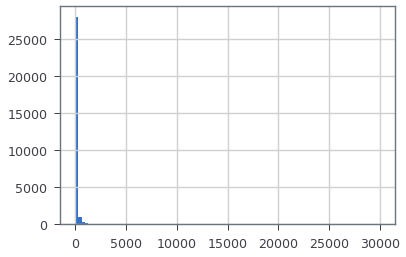

In [11]:
def show_number_of_std(dfx, name="max"):
    """ return number of std away from the mean
    dfx: DataFrame.
    name: str.
    """
    return abs(dfx.loc[name] - dfx.loc["mean"])/dfx.loc["std"]
    

target_summary_df = df[target].describe()
num_of_std_max = show_number_of_std(target_summary_df, "max")
num_of_std_min = show_number_of_std(target_summary_df, "min")
std_y = target_summary_df.loc["std"]
mean_y = target_summary_df.loc["mean"]
med_y = target_summary_df.loc["50%"]
display(target_summary_df)
print(f"{target} distribution")
display(df[target].hist(bins=100))

TARGET(PRICE_IN_LACS)_log distribution


<AxesSubplot:>

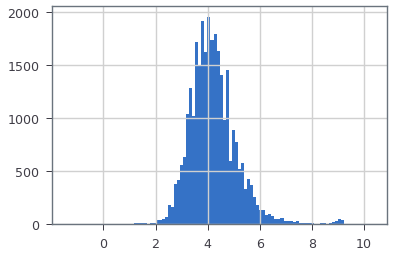

In [12]:
print(f"{target}_log distribution")
display(df[f"{target}_log"].hist(bins=100))

In [13]:
print("Right skew: heavy tail distribution in the target. "
      f"Price: mean = {mean_y}, median ={med_y}, std = {std_y}. "
      f"The number of max value has {num_of_std_max} away from the mean. "
      f"The number of min value has {num_of_std_min} away from the mean. "
      )

Right skew: heavy tail distribution in the target. Price: mean = 142.8987457132186, median =62.0, std = 656.8807127981115. The number of max value has 45.45285113807747 away from the mean. The number of min value has 0.21716080702929827 away from the mean. 


### EAD: categorical features

Plot histogram for each categorical features. Most of categorical features are unbalanced.
UNDER_CONSTRUCTION and READY_TO_MOVE are the same behavior. 
BHK_OR_RK is very unbalanced. (BHK_OR_RK == BHK) has ~99.9% population.

In [14]:
categorical_features

['POSTED_BY',
 'UNDER_CONSTRUCTION',
 'RERA',
 'BHK_OR_RK',
 'READY_TO_MOVE',
 'RESALE',
 'SUB_CITY',
 'CITY']

array([[<AxesSubplot:title={'center':'UNDER_CONSTRUCTION'}>,
        <AxesSubplot:title={'center':'RERA'}>],
       [<AxesSubplot:title={'center':'READY_TO_MOVE'}>,
        <AxesSubplot:title={'center':'RESALE'}>]], dtype=object)

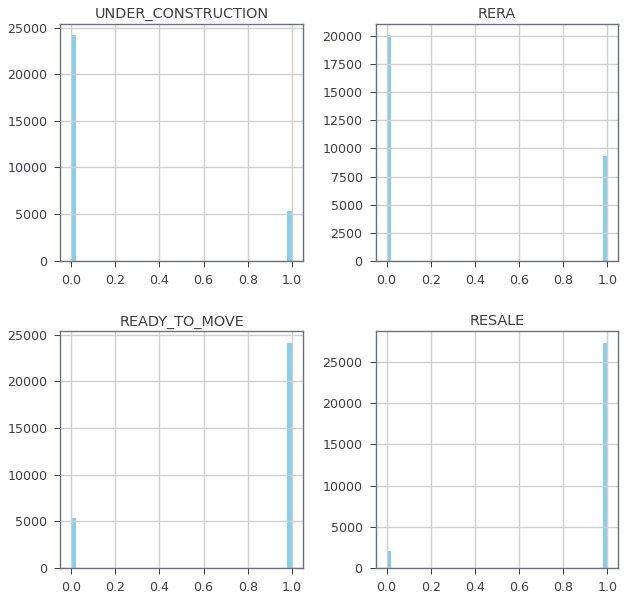

In [15]:
# Within categorical features, the population at each label of each categorical feature
# are imbalance.
df[categorical_features].hist(bins=50,figsize=(10,10), color="skyblue")

<AxesSubplot:>

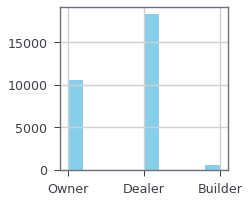

In [16]:
df["POSTED_BY"].hist(figsize=(3,3), color="skyblue")

<AxesSubplot:>

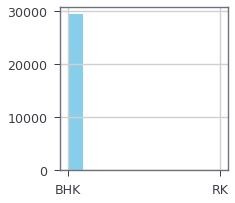

In [17]:
df["BHK_OR_RK"].hist(figsize=(3,3), color="skyblue")

In CITY feature, 44.5% of cases comes from 5 citis. Bangalore, Lalitpur, Mumbai, Pune, Noida.
Also, CITY has 256 classes. SUB_CITY has ~6000 classes.

In [18]:
# unbalanced case in categorical_features. 
# For example, in BHK_OR_RK, 99.9% of cases belongs to BHK.
# Also, UNDER_CONSTRUCTION and READY_TO_MOVE have exactly opposite behavior.
# if UNDER_CONSTRUCTION = 0, READY_TO_MOVE=1
# In city feature, 44.5% of cases comes from 5 citis. 
# Bangalore, Lalitpur, Mumbai, Pune, Noida
for cat_f in categorical_features:
    print(cat_f)
    print(df[cat_f].value_counts())
    print("-"*100)

POSTED_BY
Dealer     18291
Owner      10538
Builder      622
Name: POSTED_BY, dtype: int64
----------------------------------------------------------------------------------------------------
UNDER_CONSTRUCTION
0    24157
1     5294
Name: UNDER_CONSTRUCTION, dtype: int64
----------------------------------------------------------------------------------------------------
RERA
0    20088
1     9363
Name: RERA, dtype: int64
----------------------------------------------------------------------------------------------------
BHK_OR_RK
BHK    29427
RK        24
Name: BHK_OR_RK, dtype: int64
----------------------------------------------------------------------------------------------------
READY_TO_MOVE
1    24157
0     5294
Name: READY_TO_MOVE, dtype: int64
----------------------------------------------------------------------------------------------------
RESALE
1    27377
0     2074
Name: RESALE, dtype: int64
--------------------------------------------------------------------------------

In [19]:
# In this dataset, UNDER_CONSTRUCTION and READY_TO_MOVE have
# exactly the same behavior. Remove READY_TO_MOVE.
categorical_features.remove("READY_TO_MOVE")
all(df.eval("UNDER_CONSTRUCTION + READY_TO_MOVE") == 1)

True

#### Check unique values for categorical features

In [20]:
# most categorical features have less than 3 classes.
# CITY has 256 classes. SUB_CITY has ~6000 classes.
summary_cat_df = []
for cat_f in categorical_features:
    n = df[cat_f].nunique()
    cl_arr = map(str, list(df[cat_f].unique()))
    class_name = ",".join(cl_arr)
    summary_cat_df += [[cat_f, n, class_name]]
    
summary_cat_df = pd.DataFrame(summary_cat_df, columns=["categorical_features", "number_of_class", "class_name"])
display(summary_cat_df)

,categorical_features,number_of_class,class_name
0,POSTED_BY,3,"Owner,Dealer,Builder"
1,UNDER_CONSTRUCTION,2,"0,1"
2,RERA,2,"0,1"
3,BHK_OR_RK,2,"BHK,RK"
4,RESALE,2,"1,0"
5,SUB_CITY,5915,"Ksfc Layout,Vishweshwara Nagar,Jigani,Sector-1..."
6,CITY,256,"Bangalore,Mysore,Ghaziabad,Kolkata,Kochi,Jaipu..."


#### Check target distribution for each categorical features

For each categorical feature, we groupby it to calculate the mean and std of price.
In some categorical features, the avg prices from different labels are different. 
For example, in POSTED_BY, the avg price of Owner is 60.67. The other are ~200.
But, the std are also large. Ideally, the potential good features have small std and the mean of price are different from the others.

In [21]:
# For each categorical feature, we groupby it to calculate the mean and std of price.
# In some categorical features, the avg prices from different labels are different. 
# For example, in POSTED_BY, the avg price of Owner is 60.67. The other are ~200.
# But, the std are also large.
# Ideally, the potential good features have small std and the mean of price are different from
# others.
for cat_f in categorical_features:
    print(cat_f)
    # print(df[cat_f].value_counts())
    print(df[[cat_f, target]].groupby(cat_f).agg(["mean", "std", "count"])\
          .sort_values(("TARGET(PRICE_IN_LACS)", "std")))
    print("-"*100)

POSTED_BY
          TARGET(PRICE_IN_LACS)                    
                           mean          std  count
POSTED_BY                                          
Owner                 60.674264   371.865597  10538
Dealer               186.774735   743.666281  18291
Builder              245.705627  1283.001314    622
----------------------------------------------------------------------------------------------------
UNDER_CONSTRUCTION
                   TARGET(PRICE_IN_LACS)                    
                                    mean          std  count
UNDER_CONSTRUCTION                                          
0                             125.863279   538.824247  24157
1                             220.633121  1033.648672   5294
----------------------------------------------------------------------------------------------------
RERA
     TARGET(PRICE_IN_LACS)                   
                      mean         std  count
RERA                                         
0        

In [22]:
def show_density_stack_box_plot(df, cat, num, figsize=(10,5)):
    # fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False, figsize=figsize)
    fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False, figsize=figsize)
    x = cat
    y = num
    fig.suptitle(x + "   vs   " + y, fontsize=20)
    ### distribution
    ax[0].title.set_text('density')
    for i in sorted(df[cat].unique()):
        sns.distplot(df[df[cat]==i][num], hist=False, label=i, ax=ax[0])
    ax[0].grid(True)
    ### stacked
    df_noNan = df[df[num].notnull()]
    ax[1].title.set_text('stacked')
    breaks = np.quantile(df_noNan[num], q=np.linspace(0,1,11))
    tmp = df_noNan.groupby([cat, pd.cut(df_noNan[num], breaks, duplicates='drop')]).size().unstack().T
    tmp = tmp[df_noNan[cat].unique()]
    tmp["tot"] = tmp.sum(axis=1)
    for col in tmp.drop("tot", axis=1).columns:
        tmp[col] = tmp[col] / tmp["tot"]
    tmp.drop("tot", axis=1)[sorted(df[cat].unique())].plot(kind='bar', 
                                                           stacked=True, ax=ax[1], 
                                                           legend=True, grid=True)
    ### boxplot   
    ax[2].title.set_text('box plot')
    sns.boxplot(x=cat, y=num, data=df, ax=ax[2], order=sorted(df[cat].unique()))
    ax[2].set_yscale("log")
    # ax[2].grid(True)
    ### fix figure
    plt.close(2)
    plt.close(3)
    plt.show()
    

#### Plot density / stacked / box figure to understand the distribution within categorical features.

* density plot: target distribution is shown among different classes.
* stack plot: At each interval of target, it show the relative population among different classes. For example, in stacked plot of POSTED_BY, as target (PRICE) goes higher, the percentage of POSTED_BY=DEAL (green) increased. And the others (Red and Blue) decrease.
* box plot: it show quantile information of target within different classes.
   

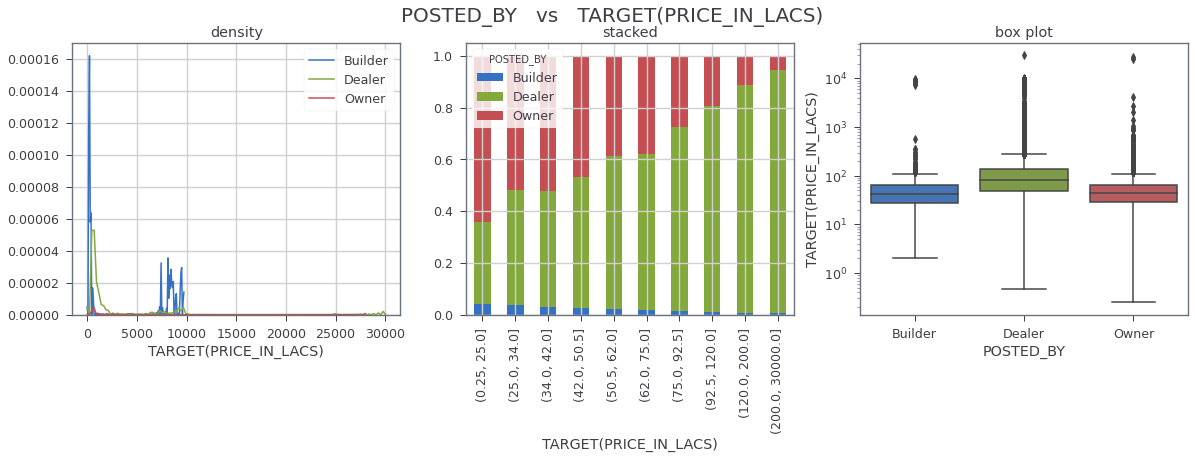

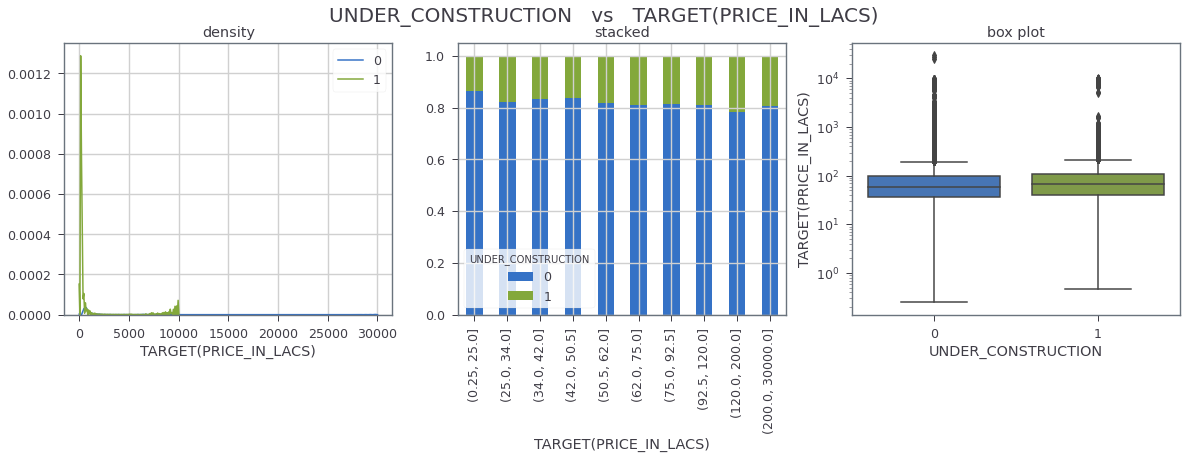

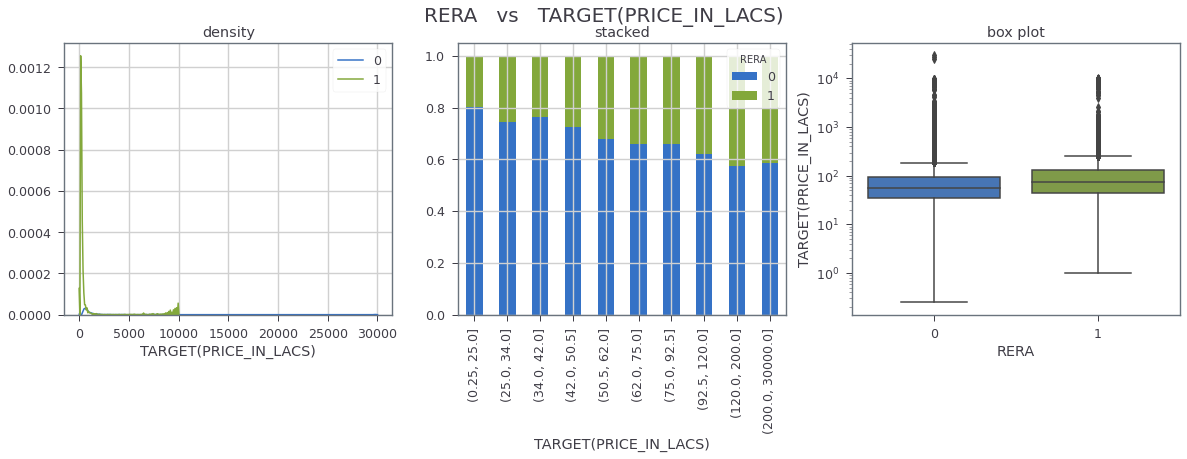

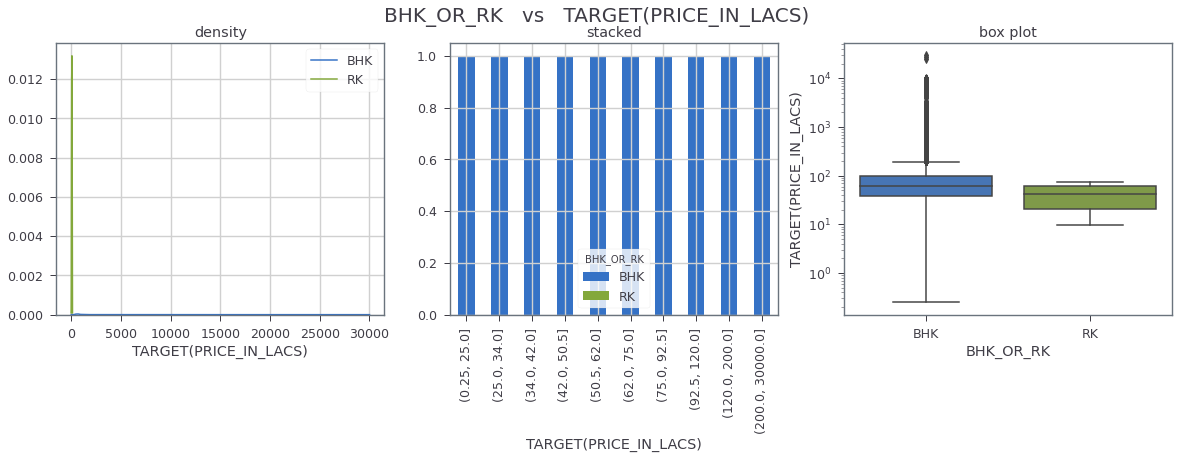

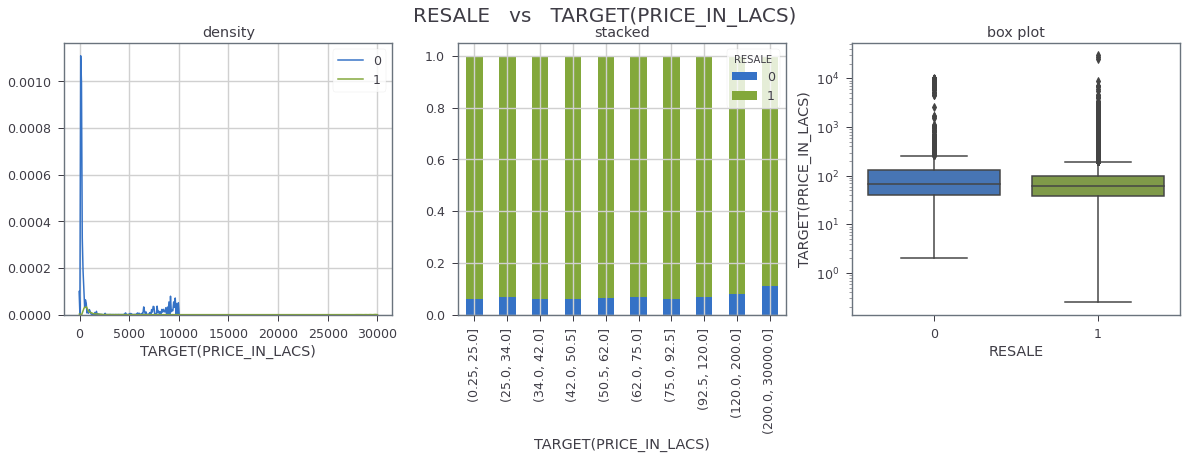

In [23]:
for cat_f in categorical_features:
    if cat_f in ['CITY', 'SUB_CITY']:
        continue
    show_density_stack_box_plot(df, cat_f, target, figsize=(20,5))

### EAD: numerical features

* BHK_NO and SQUARE_FT have right skew distribution.
* For BHK_NO and SQUARE_FT, their max values have 20 and 134 std away from their mean respectively.
In their min value, they are 1.58 and 0.01 std away from the means respectively.
* For LONGITUDE and LATITUDE, their max values have 6 and 7 std away from their mean respectively.
The min values have  9.5 and 18.8 std away from their mean respectively.
Note: quantile/power/robust transformation could be helpful to transform the heavy tail distribution into normal distribution.

In [24]:
# summary of numerical features.
# I describe the summary of each numerical features.
# For BHK_NO and SQUARE_FT, those distribution are right skew.
# Their number of std of max value away from mean are 20 and 134 respectively. -> potential outlier
# Their number of std of min value away from mean are 1.58 and 0.01 respectively. -> not outlier
# 
# For LONGITUDE and LATITUDE, the number of std of max value away from mean are 6 and 7. -> potential outlier
# For LONGITUDE and LATITUDE, the number of std of min value away from mean are 9.5 and 18.8. -> potential outlier

# Note: RobustScaler or quantile transformation could be helpful to transform the heavy tail distribution 
# into normal distribution.
num_summary_df = df[numerical_features].describe()
display(num_summary_df)
print("how many std of max value away from mean:")
print((num_summary_df.loc["max"] - num_summary_df.loc["mean"])/num_summary_df.loc["std"])
print("how many std of min value away from mean:")
print(abs(num_summary_df.loc["min"] - num_summary_df.loc["mean"])/num_summary_df.loc["std"])

,BHK_NO,SQUARE_FT,LONGITUDE,LATITUDE,SQUARE_FT_PER_ROOM
count,29451.000000,2.945100e+04,29451.000000,29451.000000,2.945100e+04
mean,2.392279,1.980217e+04,21.300255,76.837695,7.204459e+03
std,0.879091,1.901335e+06,6.205306,10.557747,6.575309e+05
min,1.000000,3.000000e+00,-37.713008,-121.761248,1.500000e+00
25%,2.000000,9.000211e+02,18.452663,73.798100,4.500248e+02
50%,2.000000,1.175057e+03,20.750000,77.324137,5.316607e+02
75%,3.000000,1.550688e+03,26.900926,77.828740,6.125527e+02
max,20.000000,2.545455e+08,59.912884,152.962676,8.484848e+07


how many std of max value away from mean:
BHK_NO                 20.029457
SQUARE_FT             133.866817
LONGITUDE               6.222518
LATITUDE                7.210344
SQUARE_FT_PER_ROOM    129.030097
dtype: float64
how many std of min value away from mean:
BHK_NO                 1.583770
SQUARE_FT              0.010413
LONGITUDE              9.510129
LATITUDE              18.810732
SQUARE_FT_PER_ROOM     0.010955
dtype: float64


### BHK_NO: number of room discussion.

There are some properties having number of room = 20. There are 4 properties having BHK_NO = 20. Only one of them has only ~348 sq-feet. With my experience, it seems impossible. Furthermore, we also look at SQUARE_FT_PER_ROOM. It also contradict my intuition that SQUARE_FT_PER_ROOM < ~20. But, overall it only has 8 data points having this issue.


In [25]:
print(df["SQUARE_FT_PER_ROOM"].describe())

count    2.945100e+04
mean     7.204459e+03
std      6.575309e+05
min      1.500000e+00
25%      4.500248e+02
50%      5.316607e+02
75%      6.125527e+02
max      8.484848e+07
Name: SQUARE_FT_PER_ROOM, dtype: float64


In [26]:
df[df["SQUARE_FT_PER_ROOM"] <= 20]

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),SUB_CITY,CITY,TARGET(PRICE_IN_LACS)_log,TARGET(PRICE_IN_LACS)_log_bin,UNIT_PRICE_PER_SQ,SQUARE_FT_PER_ROOM
2092,Owner,0,0,2,BHK,5.000000,1,1,"Sector-29 Chandigarh,Chandigarh",30.755000,76.777256,45.0,Sector-29 Chandigarh,Chandigarh,3.806662,2,9.00000,2.500000
3269,Owner,0,0,2,BHK,3.000000,1,1,"industrial area,Hajipur",23.525713,87.287479,12.0,industrial area,Hajipur,2.484907,1,4.00000,1.500000
3466,Owner,0,0,20,BHK,348.863897,1,1,"Rat,Ratnagiri",16.983330,73.300000,15.2,Rat,Ratnagiri,2.721295,1,0.04357,17.443195
13763,Owner,0,0,2,BHK,3.985594,1,1,"Amlidih,Raipur",21.213822,81.676956,24.9,Amlidih,Raipur,3.214868,1,6.24750,1.992797
15020,Owner,0,0,4,BHK,45.000191,1,1,"Swarn Jayanti Vihar,Kanpur",26.472500,80.331110,23.5,Swarn Jayanti Vihar,Kanpur,3.157000,1,0.52222,11.250048
15152,Owner,0,0,1,BHK,10.979906,1,1,"Ganesh Colony,Jalgaon",21.047939,75.770559,27.3,Ganesh Colony,Jalgaon,3.306887,1,2.48636,10.979906
24528,Owner,0,0,2,BHK,9.397110,1,1,"Brajanathchak,Haldia",22.030000,88.060000,32.5,Brajanathchak,Haldia,3.481240,1,3.45851,4.698555
26485,Owner,0,0,1,BHK,10.000000,1,1,"Punagam,Surat",21.216630,72.899374,8.0,Punagam,Surat,2.079442,1,0.80000,10.000000


array([[<AxesSubplot:title={'center':'BHK_NO'}>,
        <AxesSubplot:title={'center':'SQUARE_FT'}>],
       [<AxesSubplot:title={'center':'LONGITUDE'}>,
        <AxesSubplot:title={'center':'LATITUDE'}>],
       [<AxesSubplot:title={'center':'SQUARE_FT_PER_ROOM'}>,
        <AxesSubplot:>]], dtype=object)

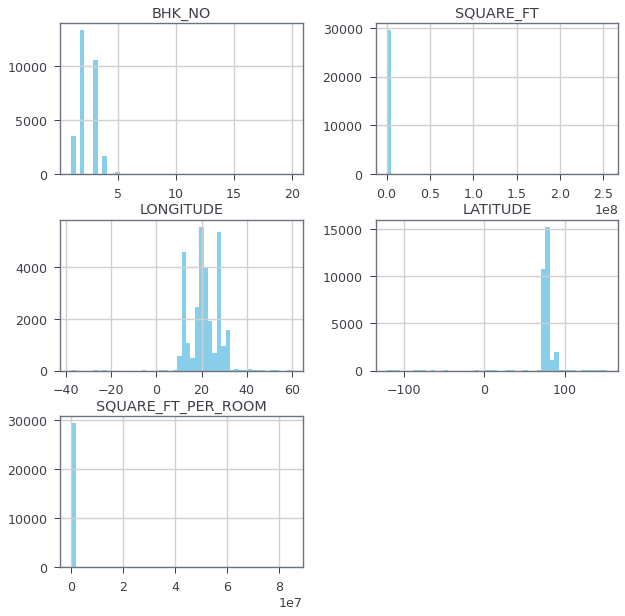

In [27]:
df[numerical_features].hist(bins=50,figsize=(10,10), color="skyblue")

#### Correlation between target and numerical features

* Among numerical features, SQUARE_FT has highest correlation 0.4 with PRICE.
* BHK_NO has very low correlation with other features. By intuition, at least, it should have some correlation with SQUARE_FT.

In [28]:
# numerical feature: SQUARE_FT has highest correlation = 0.4 with target.
df[numerical_features + [target]].corr()

,BHK_NO,SQUARE_FT,LONGITUDE,LATITUDE,SQUARE_FT_PER_ROOM,TARGET(PRICE_IN_LACS)
BHK_NO,1.000000,0.005303,0.068730,0.046930,0.004441,0.112283
SQUARE_FT,0.005303,1.000000,-0.012591,0.000803,0.993313,0.402685
LONGITUDE,0.068730,-0.012591,1.000000,-0.155062,-0.013103,-0.031112
LATITUDE,0.046930,0.000803,-0.155062,1.000000,0.000780,-0.017254
SQUARE_FT_PER_ROOM,0.004441,0.993313,-0.013103,0.000780,1.000000,0.414827
TARGET(PRICE_IN_LACS),0.112283,0.402685,-0.031112,-0.017254,0.414827,1.000000


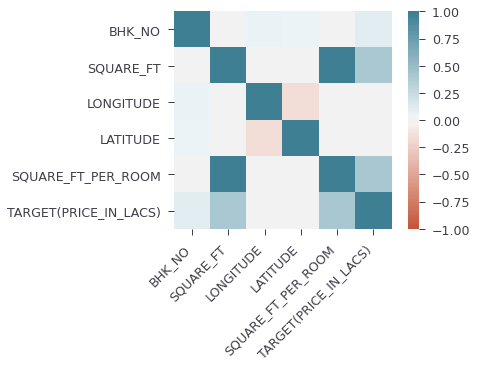

In [29]:
ax = sns.heatmap(
    df[numerical_features + [target]].corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


#### Pair for numerical features + price.

* Most of PRICE is less than 20K. There are 3 data points having PRICE >= 20K. But, we prefer to keep them in the dataset because those 3 data points also have much larger SQUARE_FT.
* BHK_NO vs PRICE: The small BHK_NO has more fluctuation than the large BHK_NO


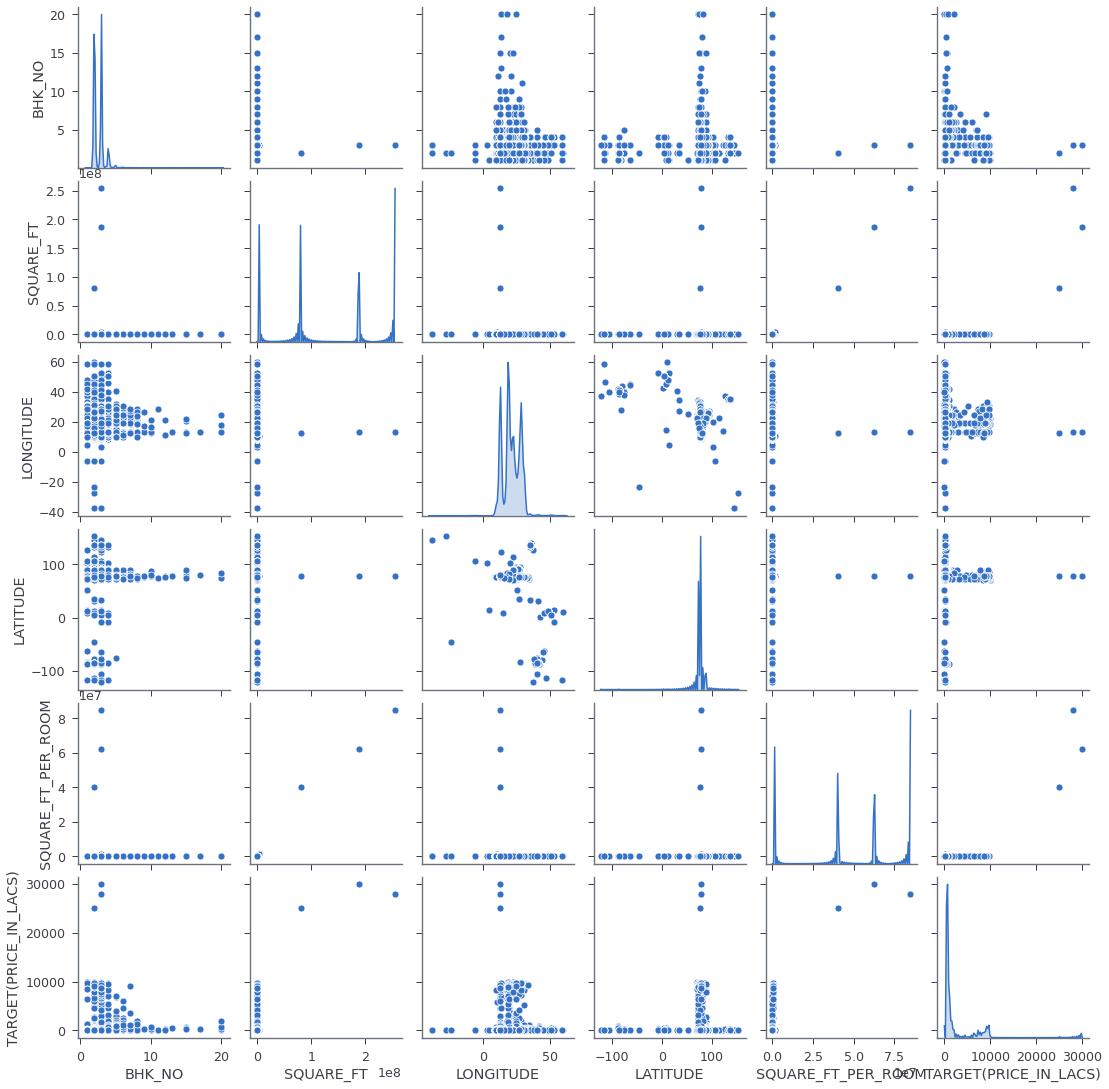

In [30]:
# mask = df[target] <= 20000
# sns.pairplot(df.loc[mask,numerical_features + [target]], diag_kind='kde')
sns.pairplot(df[numerical_features + [target]], diag_kind='kde')

In [31]:
# Calculate the p-value between target and numerical feature.
# it shows that all the numerical features are significally robust with threshold p-value = 0.05
# Especially p-value of 'BHK_NO.' and 'SQUARE_FT' is much smaller than 0.05.
_, pval = f_regression(df[numerical_features], df[target])

# p-value
print("p-value: y vs numerical feature")
dict(zip(numerical_features, pval))

p-value: y vs numerical feature


{'BHK_NO': 3.0340080036817948e-83,
 'SQUARE_FT': 0.0,
 'LONGITUDE': 9.278763453914096e-08,
 'LATITUDE': 0.0030658852286176764,
 'SQUARE_FT_PER_ROOM': 0.0}

### Analyze CITY feature

CITY is a categorical feature and has 256 unique cities. 
The goal is to find if a city is in an expensive area. It could be useful to predict price. Here we consider the following features vs CITY:
1. UNIT_PRICE_PER_SQ: avg unit price per square feet at each city.
2. BHK_NO: avg number of room at each city.
3. SQUARE_FT: avg square feet at each city.

In [32]:
# Analyze which CITY is expensive.
# Hajipur has highest unit price but it only has one data poin.
# it could be useful to derive embedding for CITY column.
# df[["CITY","UNIT_PRICE_PER_SQ"]].groupby("CITY").mean().sort_values("UNIT_PRICE_PER_SQ")
df[["CITY","UNIT_PRICE_PER_SQ"]].groupby("CITY").agg(["mean", "std", "count"])\
.sort_values(("UNIT_PRICE_PER_SQ",  "count")).reset_index()

CITY UNIT_PRICE_PER_SQ                
                                mean       std count
0         Agartala          0.055780       NaN     1
1        Midnapore          0.025640       NaN     1
2       Malappuram          0.042000       NaN     1
3    Machilipatnam          0.030560       NaN     1
4      Kurukshetra          0.070000       NaN     1
..             ...               ...       ...   ...
251          Noida          0.053539  0.022977  1767
252           Pune          0.068794  0.024428  1991
253         Mumbai          0.159192  0.106633  2023
254       Lalitpur          0.152868  0.110429  2993
255      Bangalore          0.064106  0.031626  4340

[256 rows x 4 columns]

In [33]:
df[["CITY","BHK_NO"]].groupby("CITY").agg(["mean", "std", "count"])\
.sort_values(("BHK_NO",  "count")).reset_index()

CITY    BHK_NO                
                        mean       std count
0         Agartala  2.000000       NaN     1
1        Midnapore  2.000000       NaN     1
2       Malappuram  1.000000       NaN     1
3    Machilipatnam  2.000000       NaN     1
4      Kurukshetra  2.000000       NaN     1
..             ...       ...       ...   ...
251          Noida  2.679683  0.774268  1767
252           Pune  2.171271  0.825047  1991
253         Mumbai  2.122590  0.858885  2023
254       Lalitpur  2.109255  0.902180  2993
255      Bangalore  2.578802  0.821756  4340

[256 rows x 4 columns]

In [34]:
df[["CITY","SQUARE_FT"]].groupby("CITY").agg(["mean", "std", "count"])\
.sort_values(("SQUARE_FT",  "count")).reset_index()

CITY      SQUARE_FT                    
                             mean           std count
0         Agartala     950.161348           NaN     1
1        Midnapore     780.031201           NaN     1
2       Malappuram     573.809524           NaN     1
3    Machilipatnam     719.895288           NaN     1
4      Kurukshetra     400.000000           NaN     1
..             ...            ...           ...   ...
251          Noida    2337.568562  1.069264e+04  1767
252           Pune    1641.121996  5.882493e+03  1991
253         Mumbai    1557.416224  5.243444e+03  2023
254       Lalitpur    1652.740217  7.383545e+03  2993
255      Bangalore  122511.993450  4.951679e+06  4340

[256 rows x 4 columns]

## Modeling

### Train/test split

* In order to has similar price distribution among train and test set, we take a log transformation on target and bin it. Based on target_log_bin, we use stratified-split methods to obtain train and test. Thus, in both train/test, each bin of log of price has similar population.
* In above study, only few data points has price >= 20K. However, we still keep those in the train/test dataset because removing them does not dramatically change r2 in train/test dataset.

In [35]:
from sklearn.model_selection import StratifiedShuffleSplit

In [36]:
# remove data point having prices >= 20K
# df= df[df[target] <= 20000].reset_index()
log_y_bin = f"{target}_log_bin"
split=StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=17)
for train_index,test_index in split.split(df, df[log_y_bin]):
    train=df.loc[train_index]
    test=df.loc[test_index]
print(f"train shape: {train.shape}")
print(f"train value counts on {log_y_bin}")
print(train[log_y_bin].value_counts())
print("-"*100)
print(f"test shape: {test.shape}")
print(f"test value counts on {log_y_bin}")
print(test[log_y_bin].value_counts())

train shape: (17670, 18)
train value counts on TARGET(PRICE_IN_LACS)_log_bin
1    4556
4    4384
2    4382
3    4348
Name: TARGET(PRICE_IN_LACS)_log_bin, dtype: int64
----------------------------------------------------------------------------------------------------
test shape: (11781, 18)
test value counts on TARGET(PRICE_IN_LACS)_log_bin
1    3038
4    2922
2    2922
3    2899
Name: TARGET(PRICE_IN_LACS)_log_bin, dtype: int64


### Create a model dictionary

In [37]:
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet,
                                ARDRegression, BayesianRidge, SGDRegressor,
                                HuberRegressor, RidgeCV, LassoCV, ElasticNetCV)
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor,
                               GradientBoostingRegressor)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, RobustScaler,
                                    PowerTransformer, QuantileTransformer)
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error)
from copy import deepcopy
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.compose import TransformedTargetRegressor
from sklearn.neural_network import MLPRegressor

sklearn_regression_model_dict = {
     "LinearRegression"              : LinearRegression,
     "Ridge"                         : Ridge,
     "Lasso"                         : Lasso,
     "ElasticNet"                    : ElasticNet,
     "RandomForestRegressor"         : RandomForestRegressor,
     "AdaBoostRegressor"             : AdaBoostRegressor,
     "ARDRegression"                 : ARDRegression,
     "XGBRegressor"                  : XGBRegressor,
     "LGBMRegressor"                 : LGBMRegressor,
     "SVR"                           : SVR,
     "GradientBoostingRegressor"     : GradientBoostingRegressor,
     "MLPRegressor"                  : MLPRegressor
 }

def get_metrics(y_true, y_pred):
    return {
        "rmse": [mean_squared_error(y_true, y_pred, squared=False)],
        "mae": [mean_absolute_error(y_true, y_pred)],
        "r2": [r2_score(y_true, y_pred)]
    }

### Baseline Model. Linear regression without feature engineer.

For base model, we only use subset of categorical features. And no further data transformation.

In [38]:
selected_numerical_features = [ 'BHK_NO', 
                               'SQUARE_FT', 
                               'SQUARE_FT_PER_ROOM',
                               'LONGITUDE',
                               'LATITUDE']
# only use the following 5 categorical features.
selected_categorical_features = ['POSTED_BY',
                                 'UNDER_CONSTRUCTION',
                                 # 'READY_TO_MOVE', # same as 'UNDER_CONSTRUCTION'
                                 'RERA',
                                 'BHK_OR_RK',
                                 'RESALE',
                                 # 'SUB_CITY', # too many distinct classes
                                 # 'CITY' # too many distinct classes
                                ]

In [39]:
def data_transformer(train, test, 
                     selected_numerical_features,
                     selected_categorical_features, 
                     target):
    """
    Parameters
    -------------
    train: dataframe.
    test: dataframe.
    selected_numerical_features: list[str].
    selected_categorical_features: list[str].
    target: str.
    
    Returns
    -------------
    (X_train_transformed, X_test_transformed): tuple[dataframe].
    """
    data_transformer_num = Pipeline(
         steps=[('num_scaler', QuantileTransformer())])
    data_transformer_cat = Pipeline(
         steps=[('cat_one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False))])
    preprocessor = ColumnTransformer(transformers=[
        ("num", data_transformer_num, selected_numerical_features),
        ("cat", data_transformer_cat, selected_categorical_features)
     ])
    X_train = train[selected_numerical_features + selected_categorical_features]
    y_train = train[target]
    X_test = test[selected_numerical_features + selected_categorical_features]
    y_test = test[target]
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    return (X_train_transformed, X_test_transformed, y_train, y_test, preprocessor)


In [40]:
def get_transformed_cat_feature(preprocessor, selected_categorical_features):
    transformed_cat_col = \
    preprocessor.transformers_[1][1].named_steps['cat_one_hot']\
    .get_feature_names(selected_categorical_features)
    transformed_cat_col = list(transformed_cat_col)
    return transformed_cat_col

def get_transformed_train_test_df(X_train_transformed, X_test_transformed,
                                  selected_numerical_features,
                                  transformed_cat_col):
    X_train_transformed_df = pd.DataFrame(X_train_transformed, 
                        columns=selected_numerical_features + transformed_cat_col)
    X_test_transformed_df = pd.DataFrame(X_test_transformed, 
                        columns=selected_numerical_features + transformed_cat_col)
    return (X_train_transformed_df, X_test_transformed_df)
    

#### transform train/test data using data transformer. 

In [41]:
(X_train_transformed, X_test_transformed, y_train, y_test, preprocessor) =\
data_transformer(train, 
                 test, 
                 selected_numerical_features,
                 selected_categorical_features, 
                 target)
transformed_cat_col = get_transformed_cat_feature(preprocessor, 
                                                  selected_categorical_features)

(X_train_transformed_df, X_test_transformed_df) = \
get_transformed_train_test_df(X_train_transformed, X_test_transformed,
                              selected_numerical_features,
                              transformed_cat_col)

In [42]:
X_train_transformed_df.head()

,BHK_NO,SQUARE_FT,SQUARE_FT_PER_ROOM,LONGITUDE,LATITUDE,POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,UNDER_CONSTRUCTION_0,UNDER_CONSTRUCTION_1,RERA_0,RERA_1,BHK_OR_RK_BHK,BHK_OR_RK_RK,RESALE_0,RESALE_1
0,0.000000,0.091460,0.786638,0.685686,0.783784,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.751752,0.628153,0.231784,0.199890,0.850851,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.751752,0.827828,0.667668,0.492634,0.921895,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,0.346346,0.395635,0.512223,0.163664,0.699700,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.346346,0.290261,0.326882,0.992457,0.374658,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [43]:
X_test_transformed_df.head()

,BHK_NO,SQUARE_FT,SQUARE_FT_PER_ROOM,LONGITUDE,LATITUDE,POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,UNDER_CONSTRUCTION_0,UNDER_CONSTRUCTION_1,RERA_0,RERA_1,BHK_OR_RK_BHK,BHK_OR_RK_RK,RESALE_0,RESALE_1
0,0.000000,0.018898,0.194096,0.013013,0.377377,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.346346,0.196166,0.145384,0.462462,0.086086,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.751752,0.617799,0.217634,0.658659,0.924374,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.000000,0.018418,0.189394,0.495569,0.124560,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.751752,0.762507,0.495803,0.059560,0.628128,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


In [44]:
base_model = sklearn_regression_model_dict["LinearRegression"]()
est = deepcopy(base_model)
base_model.fit(X=X_train_transformed_df, y=y_train)

LinearRegression()

In [45]:
# cv_metrics = [# "neg_mean_absolute_error",
#               "neg_root_mean_squared_error",
#               # "neg_median_absolute_error",
#               "r2",
#               # "neg_mean_absolute_percentage_error"
# ]
# cv_result = cross_validate(est, 
#                            X_train_transformed_df, 
#                            y_train,
#                            cv=5,
#                            scoring=cv_metrics,
#                            return_train_score=True)
# cv_result
# cv_result["train_r2"].mean(), cv_result["train_r2"].std()
# -cv_result["train_neg_root_mean_squared_error"].mean(), cv_result["test_neg_root_mean_squared_error"].std()

In [46]:
base_model_metrics = {"model_name": ["LinearRegression_v0"]}
train_metircs = get_metrics(y_train, base_model.predict(X_train_transformed_df))
base_model_metrics_train = {
    **base_model_metrics,
     **train_metircs,
    "data_type": ["train"]
}
test_metrics = get_metrics(y_test, base_model.predict(X_test_transformed_df))
base_model_metrics_test = {
    **base_model_metrics,
    **test_metrics,
    "data_type": ["test"]
}
base_metrics_summary_df = pd.concat([pd.DataFrame.from_dict(base_model_metrics_test),
                                    pd.DataFrame.from_dict(base_model_metrics_train)])
# print("train metrics:", train_metircs)
# print("test metrics:", test_metrics) 
display(base_metrics_summary_df)

,model_name,rmse,mae,r2,data_type
0,LinearRegression_v0,542.692852,189.496304,0.129261,test
0,LinearRegression_v0,662.071599,194.453649,0.112010,train


### Use training dataset to derive label embedding for categorical feature, CITY

For CITY feature, we create several embeddings. In each city, we calculate avg/std of
1. UNIT_PRICE_PER_SQ
2. BHK_NO
3. SQUARE_FT_PER_ROOM
4. SQUARE_FT

In [47]:
def create_embedding_for_cat(df, y, cat_f, methods=["mean", "std"]):
    """
    Parameters
    -------------
    df: dataframe.
    y: str.
    cat_f: str. categorical features.
    methods: list[str]. groupby methods.
    
    Returns
    -------------
    dfgby: dataframe.
    """
    dfgby = df[[cat_f, y]].groupby(cat_f).agg(methods).reset_index()
    dfgby.columns = [ "_".join(x) if x[1] != "" else x[0] for x in dfgby.columns]
    return dfgby.fillna(0.0)

In [48]:
city_embedding_from_unit_price = \
create_embedding_for_cat(train, y="UNIT_PRICE_PER_SQ", cat_f="CITY",
                         methods=["mean", "std", "median"])

In [49]:
city_embedding_from_BHK_NO = \
create_embedding_for_cat(train, y="BHK_NO", cat_f="CITY",
                         methods=["mean", "std", "median"])

In [50]:
city_embedding_from_SQUARE_FT_PER_ROOM = \
create_embedding_for_cat(train, y="SQUARE_FT_PER_ROOM", cat_f="CITY", 
                         methods=["mean", "std", "median"])

In [51]:
city_embedding_from_SQUARE_FT = \
create_embedding_for_cat(train, y="SQUARE_FT", cat_f="CITY", 
                         methods=["mean", "std", "median"])

In [52]:
city_embedding_from_unit_price.head()

,CITY,UNIT_PRICE_PER_SQ_mean,UNIT_PRICE_PER_SQ_std,UNIT_PRICE_PER_SQ_median
0,Agra,0.034852,0.036729,0.029145
1,Ahmednagar,0.033062,0.006076,0.033500
2,Ajmer,0.029024,0.009284,0.027900
3,Akola,0.038217,0.005307,0.039115
4,Aligarh,0.068529,0.133082,0.030760


In [53]:
city_embedding_from_BHK_NO.head()

,CITY,BHK_NO_mean,BHK_NO_std,BHK_NO_median
0,Agra,2.480000,0.646498,2.0
1,Ahmednagar,1.428571,0.646206,1.0
2,Ajmer,2.470588,0.799816,3.0
3,Akola,1.666667,1.032796,1.0
4,Aligarh,3.153846,0.898717,3.0


In [54]:
city_embedding_from_SQUARE_FT_PER_ROOM.head()

,CITY,SQUARE_FT_PER_ROOM_mean,SQUARE_FT_PER_ROOM_std,SQUARE_FT_PER_ROOM_median
0,Agra,711.732161,961.612791,542.459882
1,Ahmednagar,564.190638,133.577418,551.005803
2,Ajmer,490.684641,131.562412,483.870968
3,Akola,531.353553,123.210696,555.080843
4,Aligarh,423.411904,128.544126,440.605330


In [55]:
city_embedding_from_SQUARE_FT.head()

,CITY,SQUARE_FT_mean,SQUARE_FT_std,SQUARE_FT_median
0,Agra,1791.443704,2586.200734,1250.000000
1,Ahmednagar,752.645924,234.109354,714.765309
2,Ajmer,1185.790609,418.521608,1219.181794
3,Akola,786.939649,284.939644,655.600673
4,Aligarh,1347.334724,491.282834,1321.815990


In [56]:
# populate city_embedding into train dataset.
train_p = pd.merge(train, city_embedding_from_unit_price, on=["CITY"], how="left")
train_p = pd.merge(train_p, city_embedding_from_BHK_NO, on=["CITY"], how="left")
train_p = pd.merge(train_p, city_embedding_from_SQUARE_FT_PER_ROOM, 
                   on=["CITY"], how="left")
train_p = pd.merge(train_p, city_embedding_from_SQUARE_FT, 
                   on=["CITY"], how="left")
# populate city_embedding into test dataset.
test_p = pd.merge(test, city_embedding_from_unit_price, on=["CITY"], how="left")
test_p = pd.merge(test_p, city_embedding_from_BHK_NO, on=["CITY"], how="left")
test_p = pd.merge(test_p, city_embedding_from_SQUARE_FT_PER_ROOM, on=["CITY"], how="left")
test_p = pd.merge(test_p, city_embedding_from_SQUARE_FT, on=["CITY"], how="left")

In [57]:
train_p.head()


,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,...,UNIT_PRICE_PER_SQ_median,BHK_NO_mean,BHK_NO_std,BHK_NO_median,SQUARE_FT_PER_ROOM_mean,SQUARE_FT_PER_ROOM_std,SQUARE_FT_PER_ROOM_median,SQUARE_FT_mean,SQUARE_FT_std,SQUARE_FT_median
0,Dealer,1,0,1,BHK,626.005054,0,1,"Ghodbunder Road,Lalitpur",24.690280,...,0.128555,2.115299,0.904790,2.0,843.172535,4.112217e+03,525.366129,1710.365527,8.556774e+03,1015.054393
1,Dealer,0,0,3,BHK,1336.073998,1,1,"Korattur,Chennai",13.114624,...,0.050630,2.258367,0.878043,2.0,2889.698059,5.259852e+04,470.537215,8066.586852,1.576748e+05,967.246674
2,Dealer,0,1,3,BHK,1750.000000,1,1,"Palasuni,Bhubaneswar",20.304302,...,0.041000,2.520000,0.672768,2.0,563.141522,1.039519e+02,562.951496,1397.392202,3.666665e+02,1314.885820
3,Owner,0,0,2,BHK,1067.022341,1,1,"Horamavu Agara,Bangalore",13.031800,...,0.057690,2.578010,0.764742,3.0,73410.049210,2.219337e+06,560.039532,204375.545108,6.417732e+06,1330.120482
4,Owner,0,0,2,BHK,950.168919,1,1,"Dalhousie Cantonment,Dalhousie",32.537765,...,0.046640,2.000000,0.000000,2.0,427.546585,6.722871e+01,427.546585,855.093170,1.344574e+02,855.093170


In [58]:
# Use median value in train dataset for nan value in test dataset.
embedding_cols = ["UNIT_PRICE_PER_SQ_mean", "UNIT_PRICE_PER_SQ_std", 
                  "UNIT_PRICE_PER_SQ_median",
                  "BHK_NO_mean", "BHK_NO_std", "BHK_NO_median", 
                  "SQUARE_FT_PER_ROOM_mean", "SQUARE_FT_PER_ROOM_std", 
                  "SQUARE_FT_PER_ROOM_median",
                  "SQUARE_FT_mean", "SQUARE_FT_std", "SQUARE_FT_median"
                 ]
embedding_cols_median_value = train_p[embedding_cols].median().to_dict()
# embedding_cols_median_value

for t in embedding_cols:
    default_val = embedding_cols_median_value[t]
    test_p[t].fillna(default_val, inplace=True)

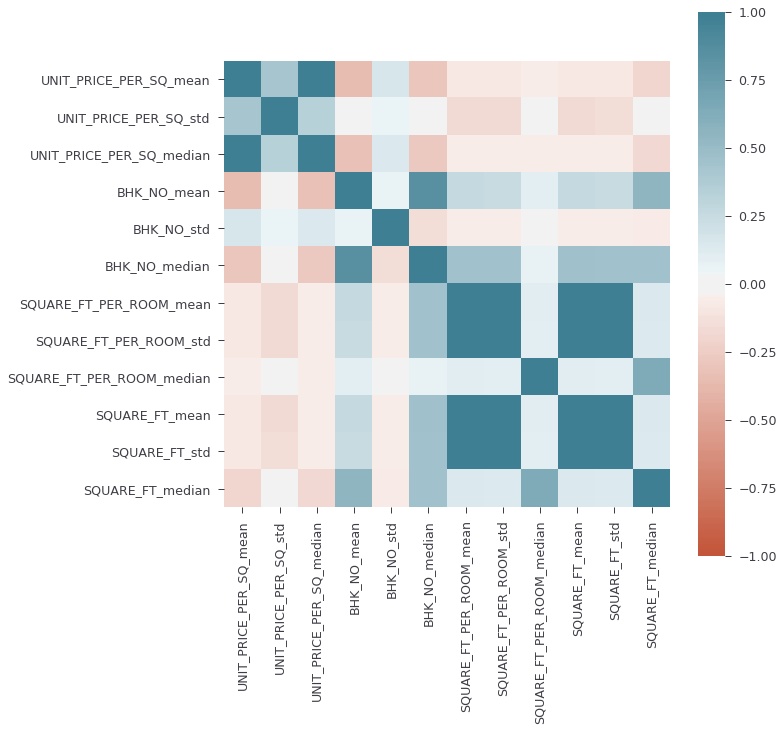

In [59]:
# train_p[embedding_cols].corr()
_, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(
    train_p[embedding_cols].corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,# figsize=(10, 10)
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
);

### BHK_NO: number of room concerns

With above discussion on number of room, due to 
* small correlation with SQ_FT.
* Square feet per room range from 1.5 to 8.5e+07. For example, there is one example having 20 rooms and sq = ~300.

It got me wonder what definition of room is. In the following, i removed BHK_NO related features.
Thus, starting from VIF, we remove BHK_NO related features. 

Use VIF to drop highly correlation features

In [60]:
from copy import deepcopy
interested_features = numerical_features + embedding_cols
# remove BHK_NO related features
interested_features = [ x for x in interested_features if "BHK_NO" not in x]
dfx = deepcopy(train_p[interested_features])
drop_threshold = 10
drop = True
to_drop_list = []
while drop:
    drop = False
    current_features = dfx.columns
    vif = [variance_inflation_factor(dfx[current_features].values, 
            dfx.columns.get_loc(f)) for f in dfx.columns]
    max_vif = max(vif)
    max_vif_index = vif.index(max_vif)
    to_drop_f = dfx.columns[max_vif_index]
    if max_vif > drop_threshold:
        print(f'Drop {dfx.columns[max_vif_index]} with vif={max_vif}')
        drop = True
        dfx.drop(to_drop_f, inplace=True, axis=1)
        to_drop_list += [to_drop_f]
    if dfx.shape[0] ==1:
        drop = False

Drop SQUARE_FT_PER_ROOM_std with vif=674323.9101235657
Drop SQUARE_FT_PER_ROOM_mean with vif=21192.45651546446
Drop SQUARE_FT_mean with vif=691.6746021199943
Drop UNIT_PRICE_PER_SQ_mean with vif=167.9876545753223
Drop SQUARE_FT_PER_ROOM with vif=75.04821168530304
Drop SQUARE_FT_PER_ROOM_median with vif=33.6181207095194
Drop LATITUDE with vif=17.100335244828536


In [61]:
to_drop_list

['SQUARE_FT_PER_ROOM_std',
 'SQUARE_FT_PER_ROOM_mean',
 'SQUARE_FT_mean',
 'UNIT_PRICE_PER_SQ_mean',
 'SQUARE_FT_PER_ROOM',
 'SQUARE_FT_PER_ROOM_median',
 'LATITUDE']

Those CITY related embedding features are highly correlated to each other. We will use VIF to check colinearity among them to remove some of them.

In [62]:

# selected_numerical_features = ['BHK_NO', 'SQUARE_FT', 'LONGITUDE', 'LATITUDE',
#                                'UNIT_PRICE_PER_SQ_mean', 'UNIT_PRICE_PER_SQ_std',
#                                'BHK_NO_mean', 'BHK_NO_std', 
#                                'SQUARE_FT_PER_ROOM_mean', 'SQUARE_FT_PER_ROOM_std',
#                               ]
selected_numerical_features = list(set(interested_features) - set(to_drop_list))
print(selected_numerical_features)
selected_categorical_features = ['POSTED_BY',
                                 'UNDER_CONSTRUCTION',
                                 # 'READY_TO_MOVE', # same as 'UNDER_CONSTRUCTION'
                                 'RERA',
                                 'BHK_OR_RK',
                                 'RESALE',
                                 # 'SUB_CITY', # too many distinct classes
                                 # 'CITY' # too many distinct classes
                                ]

['SQUARE_FT_median', 'UNIT_PRICE_PER_SQ_std', 'UNIT_PRICE_PER_SQ_median', 'SQUARE_FT', 'LONGITUDE', 'SQUARE_FT_std']


In [63]:
(X_train_transformed, X_test_transformed, y_train, y_test, preprocessor) =\
data_transformer(train_p, 
                 test_p, 
                 selected_numerical_features,
                 selected_categorical_features, 
                 target)
transformed_cat_col = get_transformed_cat_feature(preprocessor, 
                                                  selected_categorical_features)

(X_train_transformed_df, X_test_transformed_df) = \
get_transformed_train_test_df(X_train_transformed, X_test_transformed,
                              selected_numerical_features,
                              transformed_cat_col)

In [64]:
X_train_transformed_df

,SQUARE_FT_median,UNIT_PRICE_PER_SQ_std,UNIT_PRICE_PER_SQ_median,SQUARE_FT,LONGITUDE,SQUARE_FT_std,POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,UNDER_CONSTRUCTION_0,UNDER_CONSTRUCTION_1,RERA_0,RERA_1,BHK_OR_RK_BHK,BHK_OR_RK_RK,RESALE_0,RESALE_1
0,0.152152,0.919419,0.826326,0.091460,0.685686,0.611111,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.053554,0.348849,0.459960,0.628153,0.199890,0.832332,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.676176,0.175676,0.335335,0.827828,0.492634,0.061061,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,0.701201,0.554054,0.547047,0.395635,0.163664,0.868368,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.024250,0.003943,0.427840,0.290261,0.992457,0.005050,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17665,0.053554,0.348849,0.459960,0.041366,0.093823,0.832332,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
17666,0.152152,0.919419,0.826326,0.026543,0.685686,0.611111,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
17667,0.415916,0.098599,0.083584,0.649596,0.634635,0.155656,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
17668,0.406907,0.148148,0.031532,0.142208,0.611426,0.088589,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [65]:
X_test_transformed_df.describe()

,SQUARE_FT_median,UNIT_PRICE_PER_SQ_std,UNIT_PRICE_PER_SQ_median,SQUARE_FT,LONGITUDE,SQUARE_FT_std,POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,UNDER_CONSTRUCTION_0,UNDER_CONSTRUCTION_1,RERA_0,RERA_1,BHK_OR_RK_BHK,BHK_OR_RK_RK,RESALE_0,RESALE_1
count,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000
mean,0.488392,0.501546,0.491764,0.497188,0.500704,0.490959,0.020287,0.616331,0.363382,0.820134,0.179866,0.685001,0.314999,0.999066,0.000934,0.071047,0.928953
std,0.285054,0.287899,0.282574,0.287861,0.289785,0.275694,0.140986,0.486299,0.480994,0.384092,0.384092,0.464535,0.464535,0.030544,0.030544,0.256914,0.256914
min,0.001001,0.000000,0.000004,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.279780,0.246246,0.255756,0.245621,0.248749,0.247247,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,0.507007,0.554054,0.510511,0.495304,0.499268,0.478478,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.701201,0.780781,0.726226,0.745397,0.753754,0.761762,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,0.999163,0.999165,0.964965,0.999000,1.000000,0.868368,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### BHK_NO: number of room concerns

With above discussion on number of room, due to 
* small correlation with SQ_FT.
* Square feet per room range from 1.5 to 8.5e+07. For example, there is one example having 20 rooms and sq = ~300.

It got me wonder what definition of room is. In the following, i removed BHK_NO related features.

In [66]:
bhk_no_related_features = [ x for x in X_train_transformed_df.columns if "BHK_NO" in x ]
if len(bhk_no_related_features) > 0:
    X_train_transformed_df.drop(columns=bhk_no_related_features, inplace=True)
    X_test_transformed_df.drop(columns=bhk_no_related_features, inplace=True)

#### Run experiments on several models

In [67]:
def run_experiment(models_config, 
                   sklearn_regression_model_dict, 
                   X_train_transformed_df,
                   y_train,
                   X_test_transformed_df,
                   y_test):
    metrics_df = []
    model_dict = {}
    for model in models_config:
        print(model)
        model_obj = sklearn_regression_model_dict[model]()
        model_obj.fit(X_train_transformed_df, y_train)
        model_dict[model] = model_obj
        y_test_pred = model_obj.predict(X_test_transformed_df)
        test_metrics = get_metrics(y_test, y_test_pred)
        test_metrics["data_type"] = ["test"]
        y_train_pred = model_obj.predict(X_train_transformed_df)
        train_metrics = get_metrics(y_train, y_train_pred)
        train_metrics["data_type"] = ["train"]
        # metrics["model_name"] = [model]
        test_metrics_df = pd.DataFrame.from_dict({"model_name": model,
                                                   **test_metrics})
        train_metrics_df = pd.DataFrame.from_dict({"model_name": model,
                                                   **train_metrics})
        metrics_df += [pd.concat([train_metrics_df, test_metrics_df])]
        del model_obj, test_metrics, train_metrics
    metrics_df = pd.concat(metrics_df)
    return metrics_df, model_dict

In [68]:
models_config = ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 
                 'RandomForestRegressor', 'SVR', 'XGBRegressor', 
                 'GradientBoostingRegressor', 'AdaBoostRegressor', 
                 'LGBMRegressor']
metrics_df, model_dict = run_experiment(models_config, 
                   sklearn_regression_model_dict, 
                   X_train_transformed_df,
                   y_train,
                   X_test_transformed_df,
                   y_test)

LinearRegression
Ridge
Lasso
ElasticNet
RandomForestRegressor
SVR
XGBRegressor
GradientBoostingRegressor
AdaBoostRegressor
LGBMRegressor


In [69]:
metrics_df = pd.concat([base_metrics_summary_df, metrics_df])
metrics_df.sort_values(["model_name", "data_type"])

,model_name,rmse,mae,r2,data_type
0,AdaBoostRegressor,174.403017,71.350855,0.910073,test
0,AdaBoostRegressor,148.708024,69.104550,0.955201,train
0,ElasticNet,568.334557,126.105291,0.045034,test
0,ElasticNet,691.169511,132.081334,0.032241,train
0,GradientBoostingRegressor,146.874452,39.440277,0.936222,test
0,GradientBoostingRegressor,102.501211,36.242470,0.978716,train
0,LGBMRegressor,213.039829,43.937420,0.865816,test
0,LGBMRegressor,213.925732,38.522168,0.907290,train
0,Lasso,542.195998,170.810231,0.130855,test
0,Lasso,662.681773,174.397275,0.110372,train


In [70]:
metrics_df[metrics_df.data_type == "test"].sort_values(["rmse"])

,model_name,rmse,mae,r2,data_type
0,XGBRegressor,122.447060,33.285500,0.955672,test
0,RandomForestRegressor,124.742964,33.626067,0.953994,test
0,GradientBoostingRegressor,146.874452,39.440277,0.936222,test
0,AdaBoostRegressor,174.403017,71.350855,0.910073,test
0,LGBMRegressor,213.039829,43.937420,0.865816,test
0,Lasso,542.195998,170.810231,0.130855,test
0,LinearRegression_v0,542.692852,189.496304,0.129261,test
0,Ridge,543.144619,175.362180,0.127811,test
0,LinearRegression,543.169387,175.485439,0.127731,test
0,ElasticNet,568.334557,126.105291,0.045034,test


Best Model: tree models generally have better performance than linear models.

In [71]:
mask = (metrics_df.data_type == "test")
metrics_df_best = metrics_df[mask]
best_model_name = metrics_df_best[metrics_df_best.rmse 
                                  == min(metrics_df_best.rmse)]["model_name"].values[0]
metrics_df_best = metrics_df[metrics_df.model_name == best_model_name]
metrics_df_best

,model_name,rmse,mae,r2,data_type
0,XGBRegressor,42.753519,21.046892,0.996297,train
0,XGBRegressor,122.447060,33.285500,0.955672,test


### Feature Importance.

The best model is GradientBoostingRegressor. Here is feature importance.
Those important ones are SQUARE_FT, RESALE, UNIT_PRICE_PER_SQ_median.
It also make senses that the larger size of house, the more expensive it will be.

In [72]:
# numerical_features + categorical_features
def derive_raw_features(x):
    for f in categorical_features:
        if f in x:
            return f
    return x

,score
raw_feature,
BHK_OR_RK,0.000000
LONGITUDE,0.004384
POSTED_BY,0.002860
RERA,0.003780
RESALE,0.794289
SQUARE_FT,0.164336
SQUARE_FT_median,0.001967
SQUARE_FT_std,0.001015
UNDER_CONSTRUCTION,0.003346


<AxesSubplot:xlabel='raw_feature'>

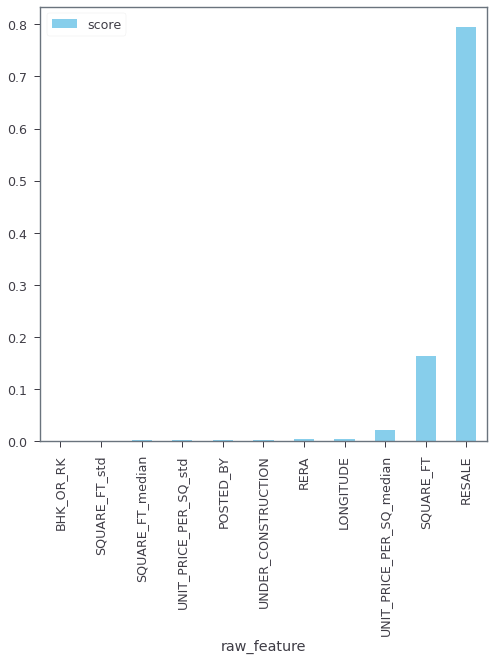

In [73]:
feature_names = X_train_transformed_df.columns.tolist()
f_importances = model_dict[best_model_name].feature_importances_
# forest_importances = pd.DataFrame(data=f_importances, index=feature_names, columns=["score"])
df_importances = pd.DataFrame(data=zip(feature_names, f_importances), 
                                  columns=["features","score"]).sort_values("score")
df_importances["raw_feature"] = df_importances["features"].apply(lambda x: derive_raw_features(x))
feature_summary = df_importances[["raw_feature", "score"]].groupby("raw_feature").sum()
# forest_importances.set_index("features").plot.bar(figsize=(8, 8))
display(feature_summary)
feature_summary.sort_values("score").plot.bar(figsize=(8, 8), color="skyblue")

In [74]:
## try target transformation. the test metrics is not as good as before.
target_transformation = False
if target_transformation:
    metrics_df = []
    for model in models_config:
        print(model)
        model_obj_0 = sklearn_regression_model_dict[model]()
        model_obj = TransformedTargetRegressor(regressor=model_obj_0,
                                            func=np.log, inverse_func=np.exp)
        model_obj.fit(X_train_transformed_df, y_train)
        y_test_pred = model_obj.predict(X_test_transformed_df)
        test_metrics = get_metrics(y_test, y_test_pred)
        test_metrics["data_type"] = ["test"]
        y_train_pred = model_obj.predict(X_train_transformed_df)
        train_metrics = get_metrics(y_train, y_train_pred)
        train_metrics["data_type"] = ["train"]
        # metrics["model_name"] = [model]
        test_metrics_df = pd.DataFrame.from_dict({"model_name": model,
                                                   **test_metrics})
        train_metrics_df = pd.DataFrame.from_dict({"model_name": model,
                                                   **train_metrics})
        metrics_df += [pd.concat([train_metrics_df, test_metrics_df])]
        del model_obj, test_metrics, train_metrics
    metrics_df = pd.concat(metrics_df)

### GridSearch

In [75]:
RandomForestRegressor_config = {
    "n_estimators": [100, 200, 500, 800],
    "max_depth": [5, 10, 15],
    "max_features" : ["auto", "sqrt", "log2", None],
    "max_leaf_nodes" : [None, 10, 20],
    "max_samples" : [None],
    "min_impurity_decrease": [0.0],
    "min_impurity_split": [None],
    "min_samples_leaf": [1, 3, 5],
    "min_samples_split": [2, 5, 10],
    "min_weight_fraction_leaf": [0.0],
    "bootstrap": [True, False],
    "random_state": [17]
}

XGBRegressor_config = {
     "n_estimators"       : [100, 500],
     "booster"            : ["gbtree", "gblinear", "dart"],
     # "tree_method"        : ["auto", "exact", "approx", "hist"],
     "max_depth"          : [5, 15],
     # "eta"                : [0.1, 0.8],
     # "gamma"              : [0.1, 10.0],
     "min_child_weight"   : [1, 5, 10],
     # "colsample_bytree"   : [0.5, 0.8],
     "learning_rate"      : [0.01],
     "subsample"          : [0.7, 1]
}

GradientBoostingRegressor_config = {
    # 'n_estimators':[200, 500],
    'n_estimators':[200, 500, 1000],
    'learning_rate':[0.01],
    'max_depth':[6, 8],
    # 'subsample':[0.5, 0.75],
    'subsample':[0.2, 0.5, 0.75],
    'random_state':[1],
    'max_features': ['sqrt'],
    'max_leaf_nodes': [None, 3, 5],
    'alpha': [0.5, 0.9],
    'min_samples_leaf': [1, 5]
}

MLPRegressor_config = {
     "hidden_layer_sizes" : [(200, 100), (500, 200), (50, 50, 50)],
     "activation"         : ["identity", "logistic", "tanh", "relu"],
     # "activation"         : ["relu"],
     "solver": ["adam"],
     "max_iter": [1000],
     # "early_stopping": [True],
     # "validation_fraction": [0.1],
     # "beta_1": [0.1, 0.5],
     # "beta_2": [0.1, 0.5],
     # "epsilon": [1e-6, 1e-8],
     # "n_iter_no_change": [10, 20]
 }

grid_search_config = {
    "RandomForestRegressor" : RandomForestRegressor_config,
    "XGBRegressor": XGBRegressor_config,
    "GradientBoostingRegressor": GradientBoostingRegressor_config,
 "MLPRegressor":    MLPRegressor_config
}

In [76]:
def run_grid_search_experiment(grid_search_config,
                               sklearn_regression_model_dict,
                               model,
                               X_train_transformed_df,
                               y_train,
                               X_test_transformed_df,
                               y_test):
    # model = "GradientBoostingRegressor"
    gs_param = grid_search_config.get(model)
    gs_model = GridSearchCV(sklearn_regression_model_dict[model](),
                            gs_param, 
                            verbose=2,
                            n_jobs=-1,
                            cv=5)
    gs_model.fit(X_train_transformed_df, y_train)
    best_est = gs_model.best_estimator_
    y_test_pred = best_est.predict(X_test_transformed_df)
    test_metrics = get_metrics(y_test, y_test_pred)
    test_metrics["data_type"] = ["test"]
    y_train_pred = best_est.predict(X_train_transformed_df)
    train_metrics = get_metrics(y_train, y_train_pred)
    train_metrics["data_type"] = ["train"]
    test_metrics_df = pd.DataFrame.from_dict({"model_name": model,
                                                   **test_metrics})
    train_metrics_df = pd.DataFrame.from_dict({"model_name": model,
                                                   **train_metrics})
    metrics_df = pd.concat([train_metrics_df, test_metrics_df])
    print(f"Best fit param: {gs_model.best_params_}")
    return metrics_df, gs_model, best_est

In [77]:
model = "GradientBoostingRegressor"
t0 = time()

df_gb, gs_model_gb, best_est_gb = run_grid_search_experiment(grid_search_config,
                                   sklearn_regression_model_dict,
                                   model,
                                   X_train_transformed_df,
                                   y_train,
                                   X_test_transformed_df,
                                   y_test)
display(df_gb)
t1 = time()
print((t1- t0)/60)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best fit param: {'alpha': 0.5, 'learning_rate': 0.01, 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'n_estimators': 1000, 'random_state': 1, 'subsample': 0.75}


,model_name,rmse,mae,r2,data_type
0,GradientBoostingRegressor,72.725112,29.379076,0.989286,train
0,GradientBoostingRegressor,122.335724,36.121198,0.955753,test


5.473708844184875


In [78]:
t0 = time()
model = "XGBRegressor"
df_xgb, gs_model_xgb, best_est_xgb = run_grid_search_experiment(grid_search_config,
                                   sklearn_regression_model_dict,
                                   model,
                                   X_train_transformed_df,
                                   y_train,
                                   X_test_transformed_df,
                                   y_test)
display(df_xgb)
t1 = time()
print((t1- t0)/60)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best fit param: {'booster': 'dart', 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.7}


,model_name,rmse,mae,r2,data_type
0,XGBRegressor,97.619726,35.153485,0.980695,train
0,XGBRegressor,130.350172,38.352445,0.949765,test


59.43586453596751


### Stacking Regressor: use output of other regressors as input in the final regressor.

The RMSE is similar to the result from GradientBoostingRegressor only.
* Here we manually selected models into basic estimators and final estimator. We try 2 combination.
  * case 1: basic estimators are tree models. final estimator is linear regression.
  * case 2: basic estimators are linear models. final estimator is gradient boosting tree.
* The performance of case 1 is better. Those basic estimators generate features for the final estimator. It means if good features exist in the dataset, linear model is good enough.

In [79]:
from sklearn.ensemble import StackingRegressor

In [80]:
t0 = time()

model = "stacking_regressor"
estimators = [
    ('gb', GradientBoostingRegressor()),
    ('rf', RandomForestRegressor()),
    ('xgb', XGBRegressor())
]

stack_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=sklearn_regression_model_dict["ElasticNet"]())

stack_reg.fit(X_train_transformed_df, y_train)
t1 = time()

# model_dict[model] = stack_reg
y_test_pred = stack_reg.predict(X_test_transformed_df)
test_metrics = get_metrics(y_test, y_test_pred)
test_metrics["data_type"] = ["test"]
y_train_pred = stack_reg.predict(X_train_transformed_df)
train_metrics = get_metrics(y_train, y_train_pred)
train_metrics["data_type"] = ["train"]
# metrics["model_name"] = [model]
test_metrics_df = pd.DataFrame.from_dict({"model_name": model,
                                       **test_metrics})
train_metrics_df = pd.DataFrame.from_dict({"model_name": model,
                                       **train_metrics})
metrics_df = pd.concat([train_metrics_df, test_metrics_df])
print((t1- t0)/60)
display(metrics_df)

0.542201284567515


,model_name,rmse,mae,r2,data_type
0,stacking_regressor,86.895838,31.965122,0.984703,train
0,stacking_regressor,137.545867,37.459590,0.944066,test


### Voting Regressor: Take an avg of outputs from several regressors.

In [81]:
from sklearn.ensemble import VotingRegressor

In [82]:
model = "voting_regressor"
estimators = [
    ('gb', GradientBoostingRegressor()),
    ('rf', RandomForestRegressor()),
    ('xgb', XGBRegressor()),
    # ('lr', LinearRegression()),
]
vot_reg = VotingRegressor(estimators)
vot_reg.fit(X_train_transformed_df, y_train)
y_test_pred = vot_reg.predict(X_test_transformed_df)
test_metrics = get_metrics(y_test, y_test_pred)
test_metrics["data_type"] = ["test"]
y_train_pred = vot_reg.predict(X_train_transformed_df)
train_metrics = get_metrics(y_train, y_train_pred)
train_metrics["data_type"] = ["train"]
# metrics["model_name"] = [model]
test_metrics_df = pd.DataFrame.from_dict({"model_name": model,
                                       **test_metrics})
train_metrics_df = pd.DataFrame.from_dict({"model_name": model,
                                       **train_metrics})
metrics_df = pd.concat([train_metrics_df, test_metrics_df])

display(metrics_df)

,model_name,rmse,mae,r2,data_type
0,voting_regressor,62.317738,22.403274,0.992133,train
0,voting_regressor,123.830511,33.720055,0.954665,test


### Neural Network [sklearn]

In [83]:
grid_search_config["MLPRegressor"] = {
     "hidden_layer_sizes" : [(1000, 500), (500, 500), (500, 200)],
     "activation"         : ["identity", "logistic", "tanh", "relu"],
     # "activation"         : ["relu"],
     "solver": ["adam"],
     "max_iter": [1000],
     # "early_stopping": [True],
     "validation_fraction": [0.1, 0.2],
     "beta_1": [0.1, 0.5],
     "beta_2": [0.1, 0.5],
     # "epsilon": [1e-6, 1e-8],
     # "n_iter_no_change": [10, 20]
 }
grid_search_config["MLPRegressor"]

{'hidden_layer_sizes': [(1000, 500), (500, 500), (500, 200)],
 'activation': ['identity', 'logistic', 'tanh', 'relu'],
 'solver': ['adam'],
 'max_iter': [1000],
 'validation_fraction': [0.1, 0.2],
 'beta_1': [0.1, 0.5],
 'beta_2': [0.1, 0.5]}

In [84]:
t0 = time()
model = "MLPRegressor"
df_nn, gs_model_nn, best_est_nn = run_grid_search_experiment(grid_search_config,
                                   sklearn_regression_model_dict,
                                   model,
                                   X_train_transformed_df,
                                   y_train,
                                   X_test_transformed_df,
                                   y_test)
display(df_nn)
t1 = time()
print((t1- t0)/60)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best fit param: {'activation': 'relu', 'beta_1': 0.1, 'beta_2': 0.5, 'hidden_layer_sizes': (500, 200), 'max_iter': 1000, 'solver': 'adam', 'validation_fraction': 0.1}


,model_name,rmse,mae,r2,data_type
0,MLPRegressor,431.812200,60.369346,0.622264,train
0,MLPRegressor,265.456399,56.939206,0.791663,test


593.4095298091571


## Conclusion